In [1]:
"""
Traffic Sign Detection using ResNet50
SE4050 Deep Learning Assignment
"""

# Data handling
import numpy as np
import pandas as pd
import os
import cv2
import sys 
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# System
import warnings
warnings.filterwarnings('ignore')

# Print versions
print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Python version:", sys.version)
print("\n✅ All libraries imported successfully!")

TensorFlow version: 2.20.0
GPU Available: False
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]

✅ All libraries imported successfully!


In [2]:
# Check GPU details
print("Checking GPU availability...")
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

gpus = tf.config.list_physical_devices('GPU')
print(f"\nNumber of GPUs detected: {len(gpus)}")

if len(gpus) > 0:
    print("\n✅ GPU(s) found:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
else:
    print("\n⚠️ No GPU detected - Training will use CPU")
    print("\nPossible reasons:")
    print("1. TensorFlow CPU version installed (not GPU version)")
    print("2. CUDA/cuDNN not installed")
    print("3. GPU drivers not updated")
    print("\nTo install TensorFlow with GPU support:")
    print("  pip uninstall tensorflow")
    print("  pip install tensorflow[and-cuda]")

Checking GPU availability...
TensorFlow version: 2.20.0
Built with CUDA: False

Number of GPUs detected: 0

⚠️ No GPU detected - Training will use CPU

Possible reasons:
1. TensorFlow CPU version installed (not GPU version)
2. CUDA/cuDNN not installed
3. GPU drivers not updated

To install TensorFlow with GPU support:
  pip uninstall tensorflow
  pip install tensorflow[and-cuda]


In [3]:
"""
Traffic sign class names (manual mapping)
Since Meta.csv doesn't have names, we'll add them manually
"""

# Dictionary of class names for GTSRB dataset
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

print("✅ Class names dictionary created!")
print(f"Total classes: {len(class_names)}")
print("\nExample names:")
for i in range(5):
    print(f"  Class {i}: {class_names[i]}")

✅ Class names dictionary created!
Total classes: 43

Example names:
  Class 0: Speed limit (20km/h)
  Class 1: Speed limit (30km/h)
  Class 2: Speed limit (50km/h)
  Class 3: Speed limit (60km/h)
  Class 4: Speed limit (70km/h)


In [4]:
"""
Load the dataset CSV files
"""

# Load CSV files
train_df = pd.read_csv('../data/Train.csv')
test_df = pd.read_csv('../data/Test.csv')
meta_df = pd.read_csv('../data/Meta.csv')

# Display basic information
print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Number of classes: {len(meta_df)}")

print("\n📊 First 5 rows of Train.csv:")
print(train_df.head())

print("\n📊 Class Names (Meta.csv):")
print(meta_df.head(10))

print("\n✅ CSV files loaded successfully!")

DATASET INFORMATION
Training samples: 39,209
Test samples: 12,630
Number of classes: 43

📊 First 5 rows of Train.csv:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

📊 Class Names (Meta.csv):
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11    

CLASS DISTRIBUTION ANALYSIS
Minimum samples: 210
Maximum samples: 2250
Average samples: 912
Standard deviation: 696
Class imbalance ratio: 10.71x


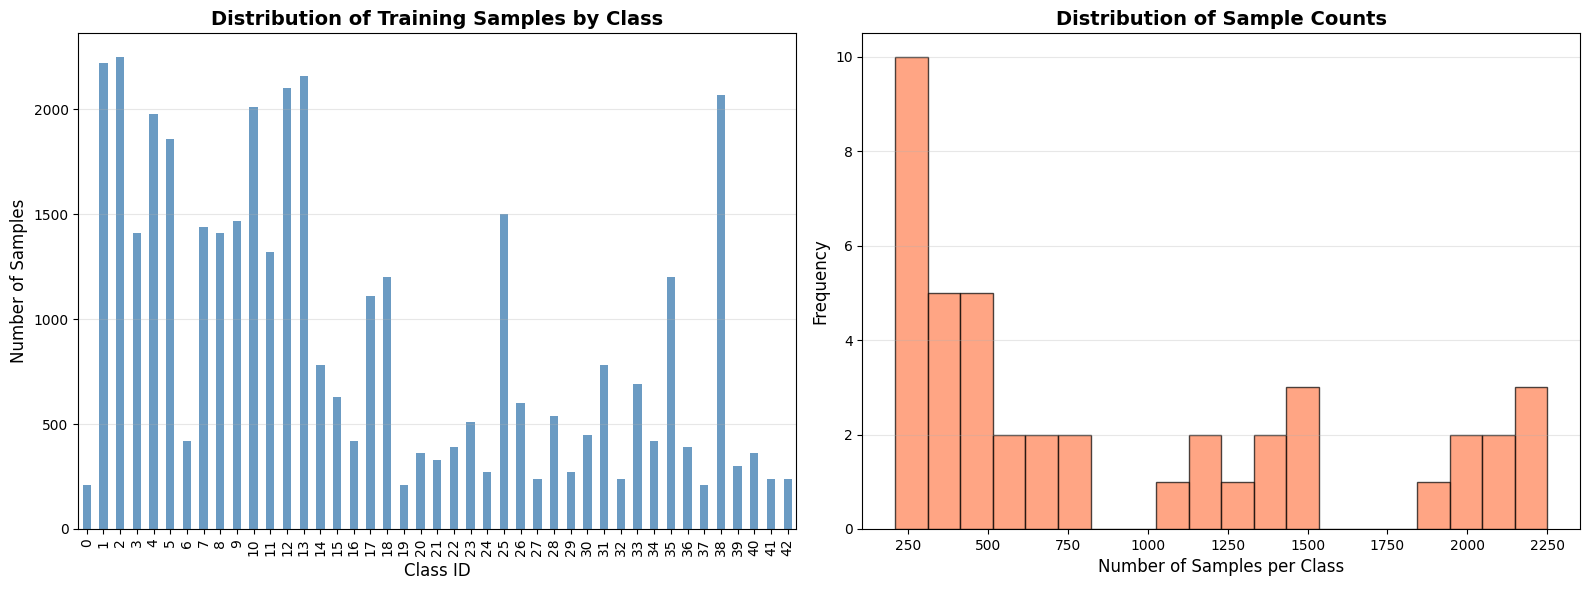


✅ Class distribution visualized!


In [5]:
"""
Analyze class distribution
"""

# Count samples per class
class_counts = train_df['ClassId'].value_counts().sort_index()

print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)
print(f"Minimum samples: {class_counts.min()}")
print(f"Maximum samples: {class_counts.max()}")
print(f"Average samples: {class_counts.mean():.0f}")
print(f"Standard deviation: {class_counts.std():.0f}")
print(f"Class imbalance ratio: {class_counts.max()/class_counts.min():.2f}x")

# Plot class distribution
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Distribution of Training Samples by Class', fontsize=14, fontweight='bold')
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(class_counts.values, bins=20, color='coral', alpha=0.7, edgecolor='black')
plt.title('Distribution of Sample Counts', fontsize=14, fontweight='bold')
plt.xlabel('Number of Samples per Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Class distribution visualized!")

In [6]:
# Check what columns Meta.csv actually has
print("Meta.csv columns:")
print(meta_df.columns.tolist())
print("\nFirst few rows:")
print(meta_df.head())

Meta.csv columns:
['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']

First few rows:
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22


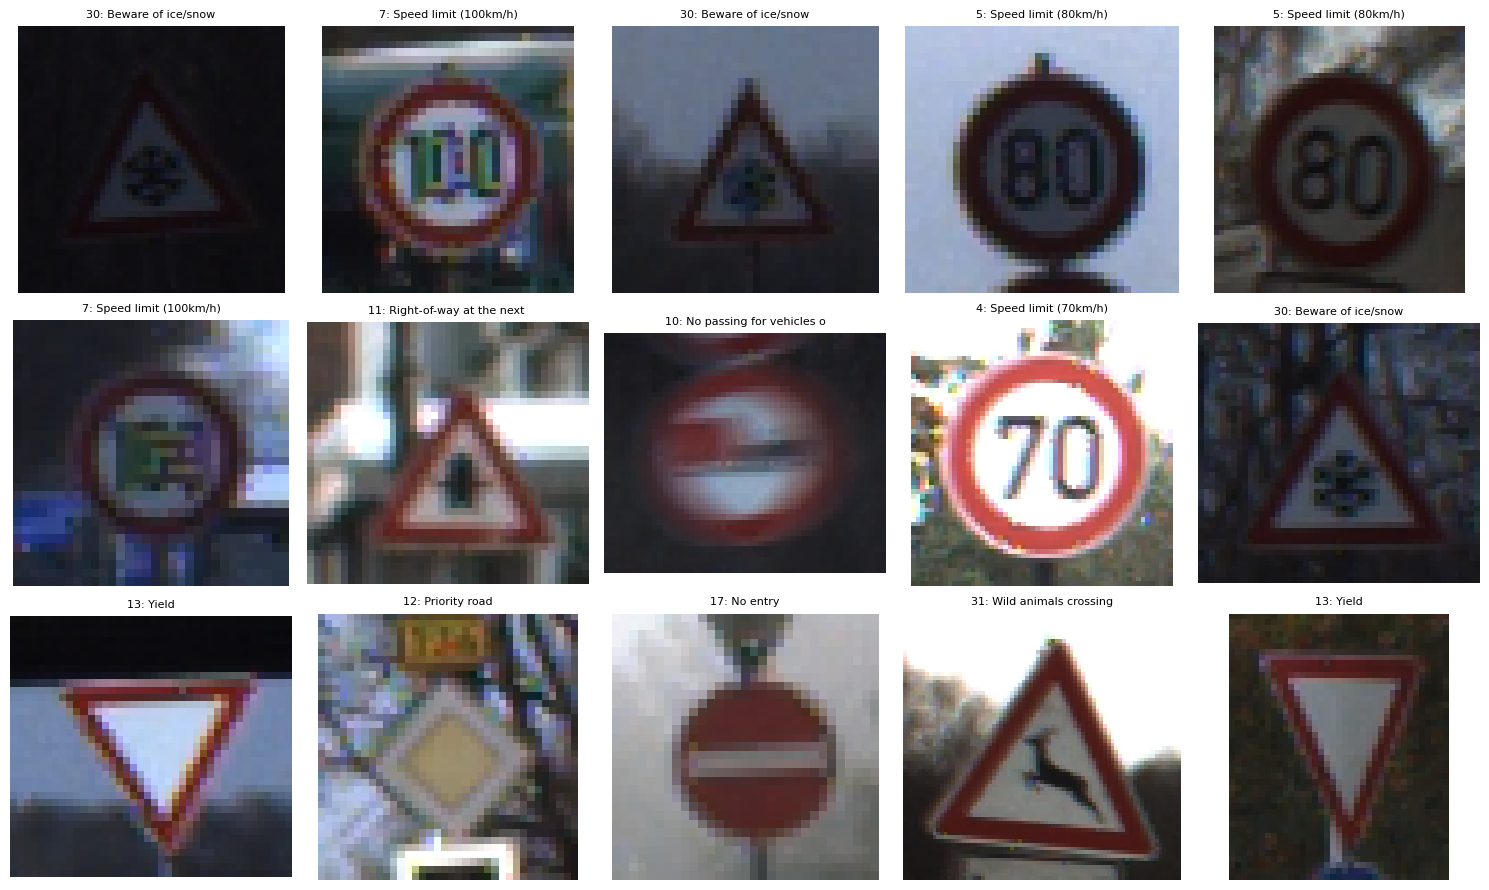

✅ Sample images displayed!


In [7]:
"""
Display sample images from different classes (with names)
"""

def display_sample_images(df, num_samples=15):
    """Display random sample images with class names"""
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(0, len(df))
        row = df.iloc[idx]
        
        # Load image
        img_path = os.path.join('../data', row['Path'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get class ID and name
        class_id = row['ClassId']
        class_name = class_names.get(class_id, f"Class {class_id}")
        
        # Display
        axes[i].imshow(img)
        axes[i].set_title(f"{class_id}: {class_name[:25]}", fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/plots/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

# Display samples
display_sample_images(train_df)
print("✅ Sample images displayed!")

In [8]:
"""
Create data generators to load images batch-by-batch
This solves memory issues and is more efficient!
"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("="*60)
print("CREATING DATA GENERATORS")
print("="*60)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize to [0,1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    validation_split=0.2             # 20% for validation
)

# Only rescaling for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

print(f"✅ Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"✅ Batch size: {BATCH_SIZE}")
print(f"✅ Train/Validation split: 80/20")
print(f"✅ Data augmentation: Enabled for training")

CREATING DATA GENERATORS
✅ Image size: 224x224
✅ Batch size: 64
✅ Train/Validation split: 80/20
✅ Data augmentation: Enabled for training


In [9]:
"""
Create training data generator from directory
"""

# Training generator
train_generator = train_datagen.flow_from_directory(
    '../data/Train',                 # Point to Train folder
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',        # Multi-class classification
    subset='training',               # Use 80% for training
    shuffle=True
)

print("="*60)
print("TRAINING GENERATOR")
print("="*60)
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Number of classes: {train_generator.num_classes}")
print(f"✅ Batches per epoch: {len(train_generator)}")
print(f"✅ Class indices sample: {list(train_generator.class_indices.items())[:5]}")

Found 31368 images belonging to 43 classes.
TRAINING GENERATOR
✅ Training samples: 31368
✅ Number of classes: 43
✅ Batches per epoch: 491
✅ Class indices sample: [('0', 0), ('1', 1), ('10', 2), ('11', 3), ('12', 4)]


In [10]:
"""
Create validation data generator
"""

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    '../data/Train',                 # Same folder but different subset
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',             # Use 20% for validation
    shuffle=False                    # Don't shuffle validation
)

print("="*60)
print("VALIDATION GENERATOR")
print("="*60)
print(f"✅ Validation samples: {validation_generator.samples}")
print(f"✅ Number of classes: {validation_generator.num_classes}")
print(f"✅ Batches: {len(validation_generator)}")

Found 7841 images belonging to 43 classes.
VALIDATION GENERATOR
✅ Validation samples: 7841
✅ Number of classes: 43
✅ Batches: 123


Batch shape: (64, 224, 224, 3)
Labels shape: (64, 43)
Pixel value range: [0.00, 1.00]


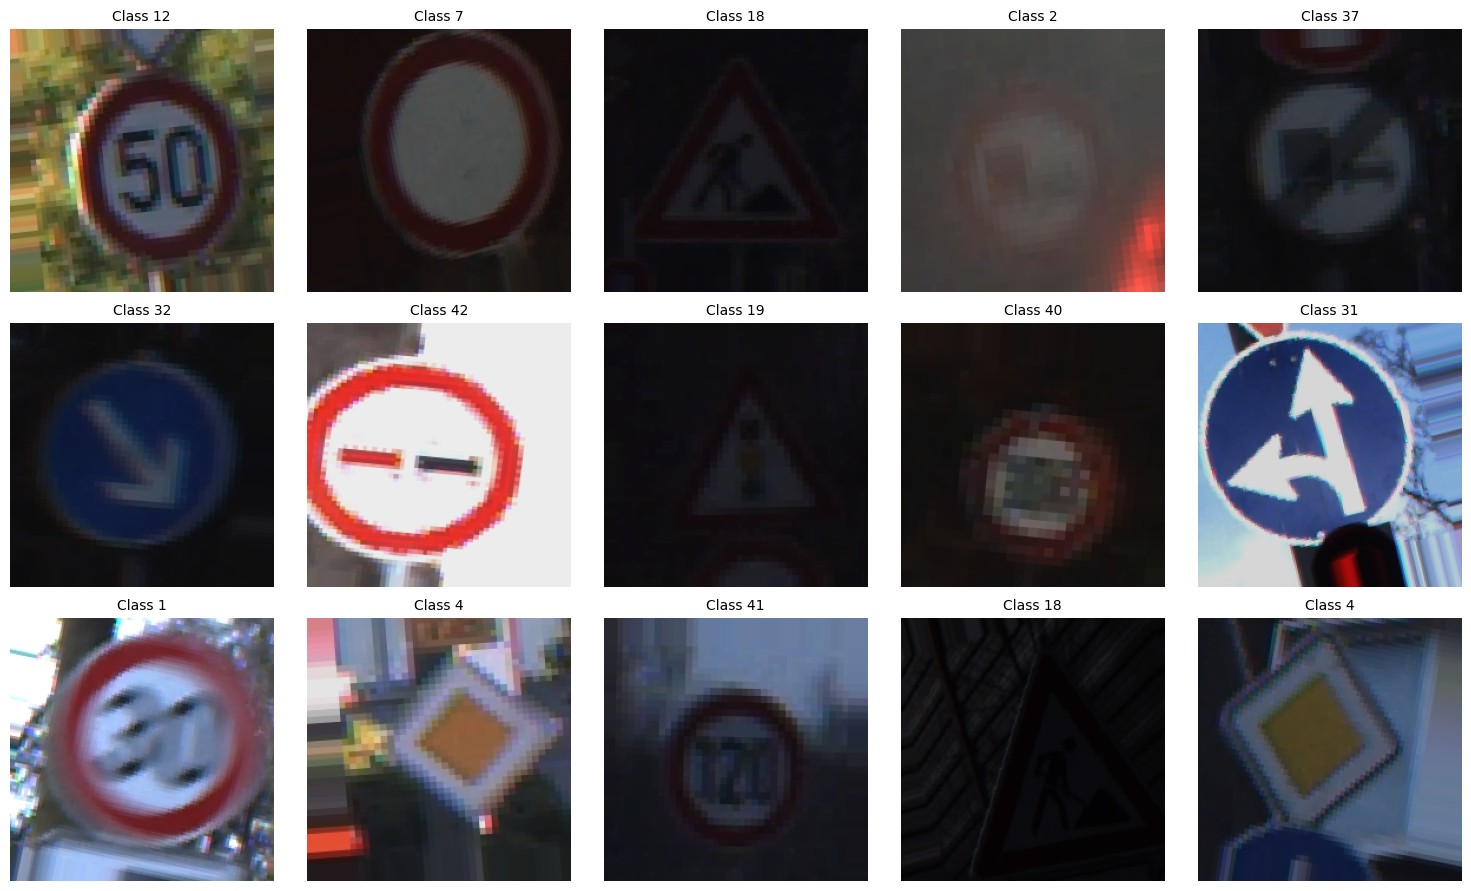

✅ Sample batch visualized!


In [11]:
"""
Visualize a sample batch from training generator
"""

# Get one batch
sample_batch_images, sample_batch_labels = next(train_generator)

print(f"Batch shape: {sample_batch_images.shape}")
print(f"Labels shape: {sample_batch_labels.shape}")
print(f"Pixel value range: [{sample_batch_images.min():.2f}, {sample_batch_images.max():.2f}]")

# Visualize sample images from batch
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(sample_batch_images[i])
    class_id = np.argmax(sample_batch_labels[i])
    axes[i].set_title(f"Class {class_id}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('../results/plots/sample_batch.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sample batch visualized!")

In [12]:
"""
Build ResNet50 model with transfer learning
"""

def build_resnet50_model(num_classes=43, input_shape=(224, 224, 3)):
    """
    Build ResNet50 model architecture
    
    Architecture:
    1. ResNet50 base (pre-trained on ImageNet) - frozen
    2. Global Average Pooling
    3. Dense layer (512 neurons)
    4. Dropout (0.5)
    5. Dense layer (256 neurons)
    6. Dropout (0.3)
    7. Output layer (43 neurons, softmax)
    """
    
    print("="*60)
    print("BUILDING RESNET50 MODEL")
    print("="*60)
    
    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',      # Use ImageNet pre-trained weights
        include_top=False,       # Don't include final classification layer
        input_shape=input_shape
    )
    
    print("✅ ResNet50 base model loaded (ImageNet weights)")
    
    # Freeze base model layers (transfer learning)
    base_model.trainable = False
    print("✅ Base model layers frozen")
    
    # Build custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(512, activation='relu', name='dense_512')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(256, activation='relu', name='dense_256')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=outputs, name='ResNet50_TrafficSigns')
    
    print("✅ Custom classification head added")
    
    # Display model architecture
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*60)
    
    # Count parameters
    trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    
    return model, base_model

# Build the model
model, base_model = build_resnet50_model(num_classes=43)

# Display detailed summary
print("\n" + "="*60)
print("DETAILED MODEL SUMMARY")
print("="*60)
model.summary()

BUILDING RESNET50 MODEL
✅ ResNet50 base model loaded (ImageNet weights)
✅ Base model layers frozen
✅ Custom classification head added

MODEL ARCHITECTURE SUMMARY
Total parameters: 24,779,179
Trainable parameters: 1,191,467
Non-trainable parameters: 23,587,712

DETAILED MODEL SUMMARY


Model: "ResNet50_TrafficSigns"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_pad (ZeroPadding2D)   │ (None, 230, 230, 3)     │              0 │ input_layer[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_conv (Conv2D)         │ (None, 112, 112, 64)    │          9,472 │ conv1_pad[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_bn                    │ (None, 112, 112, 64)    │            256 │ conv1_conv[0][0]        │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_relu (Activation)     │ (None, 112, 112, 64)    │              0 │ conv1_bn[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pool1_pad (ZeroPadding2D)   │ (None, 114, 114, 64)    │              0 │ conv1_relu[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pool1_pool (MaxPooling2D)   │ (None, 56, 56, 64)      │              0 │ pool1_pad[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_conv         │ (None, 56, 56, 64)      │          4,160 │ pool1_pool[0][0]        │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_bn           │ (None, 56, 56, 64)      │            256 │ conv2_block1_1_conv[0]… │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_relu         │ (None, 56, 56, 64)      │              0 │ conv2_block1_1_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_conv         │ (None, 56, 56, 64)      │         36,928 │ conv2_block1_1_relu[0]… │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_bn           │ (None, 56, 56, 64)      │            256 │ conv2_block1_2_conv[0]… │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_relu         │ (None, 56, 56, 64)      │              0 │ conv2_block1_2_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_0_conv         │ (None, 56, 56, 256)     │         16,640 │ pool1_pool[0][0]        │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_3_conv         │ (None, 56, 56, 256)     │    

 Total params: 24,779,179 (94.53 MB)

 Trainable params: 1,191,467 (4.55 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
"""
Compile the model with optimizer, loss function, and metrics
"""

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate 0.001
    loss='categorical_crossentropy',      # For multi-class classification
    metrics=['accuracy']                   # Track accuracy
)

print("="*60)
print("MODEL COMPILATION")
print("="*60)
print("✅ Optimizer: Adam (learning_rate=0.001)")
print("✅ Loss function: Categorical Crossentropy")
print("✅ Metrics: Accuracy")
print("\n✅ Model compiled successfully!")

MODEL COMPILATION
✅ Optimizer: Adam (learning_rate=0.001)
✅ Loss function: Categorical Crossentropy
✅ Metrics: Accuracy

✅ Model compiled successfully!


In [14]:
"""
Setup callbacks for training:
- EarlyStopping: Stop if validation loss doesn't improve
- ReduceLROnPlateau: Reduce learning rate if validation loss plateaus
- ModelCheckpoint: Save best model
"""

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop after 5 epochs of no improvement
    restore_best_weights=True,   # Restore weights from best epoch
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.5,                  # Reduce LR by half
    patience=3,                  # Wait 3 epochs before reducing
    min_lr=1e-7,                 # Minimum learning rate
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='../models/resnet50_best.h5',
    monitor='val_accuracy',      # Monitor validation accuracy
    save_best_only=True,         # Only save the best model
    mode='max',                  # Maximize validation accuracy
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, checkpoint]

print("="*60)
print("TRAINING CALLBACKS")
print("="*60)
print("✅ EarlyStopping: patience=5, monitor=val_loss")
print("✅ ReduceLROnPlateau: factor=0.5, patience=3")
print("✅ ModelCheckpoint: saving best model to ../models/resnet50_best.h5")
print("\n✅ Callbacks configured!")

TRAINING CALLBACKS
✅ EarlyStopping: patience=5, monitor=val_loss
✅ ReduceLROnPlateau: factor=0.5, patience=3
✅ ModelCheckpoint: saving best model to ../models/resnet50_best.h5

✅ Callbacks configured!


In [ ]:
"""
Train the ResNet50 model using data generators
This uses MUCH LESS memory!
"""

# Training configuration
EPOCHS = 50

print("="*60)
print("TRAINING RESNET50 MODEL")
print("="*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {train_generator.samples:,}")
print(f"Validation samples: {validation_generator.samples:,}")
print(f"Steps per epoch: {len(train_generator)}")
print("\n🚀 Starting training... This may take 30-40 minutes\n")

# Train model with generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)

TRAINING RESNET50 MODEL
Epochs: 50
Batch size: 64
Training samples: 31,368
Validation samples: 7,841
Steps per epoch: 491

🚀 Starting training... This may take 30-40 minutes

Epoch 1/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0652 - loss: 3.5554
Epoch 1: val_accuracy improved from None to 0.07945, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - accuracy: 0.0713 - loss: 3.4836 - val_accuracy: 0.0795 - val_loss: 3.3601 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0771 - loss: 3.4032
Epoch 2: val_accuracy improved from 0.07945 to 0.08532, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.0833 - loss: 3.3807 - val_accuracy: 0.0853 - val_loss: 3.2521 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0973 - loss: 3.3171
Epoch 3: val_accuracy improved from 0.08532 to 0.13187, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.1024 - loss: 3.3014 - val_accuracy: 0.1319 - val_loss: 3.1297 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1079 - loss: 3.2707
Epoch 4: val_accuracy improved from 0.13187 to 0.16886, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.1092 - loss: 3.2597 - val_accuracy: 0.1689 - val_loss: 3.1124 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1150 - loss: 3.2338
Epoch 5: val_accuracy did not improve from 0.16886
491/491 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.1172 - loss: 3.2158 - val_accuracy: 0.1163 - val_loss: 3.0632 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1257 - loss: 3.1796
Epoch 6: val_accuracy improved from 0.16886 to 0.16962, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.1298 - loss: 3.1574 - val_accuracy: 0.1696 - val_loss: 2.9210 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1376 - loss: 3.1154
Epoch 7: val_accuracy did not improve from 0.16962
491/491 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.1360 - loss: 3.1088 - val_accuracy: 0.1687 - val_loss: 2.9124 - learning_rate: 0.0010
Epoch 8/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1348 - loss: 3.0896
Epoch 8: val_accuracy improved from 0.16962 to 0.19946, saving model to ../models/resnet50_best.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.1371 - loss: 3.0962 - val_accuracy: 0.1995 - val_loss: 2.9037 - learning_rate: 0.0010
Epoch 9/50
 38/491 ━━━━━━━━━━━━━━━━━━━━ 10:05 1s/step - accuracy: 0.1401 - loss: 3.0811

In [ ]:
"""
Save training history for later analysis
"""

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('../results/history/resnet50_history.csv', index=False)

print("Training History:")
print(history_df.tail())

print("\n✅ Training history saved to ../results/history/resnet50_history.csv")

In [ ]:
"""
Visualize training and validation accuracy/loss over epochs
"""

def plot_training_history(history):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
    axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
    axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/plots/resnet50_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
plot_training_history(history)

print("✅ Training history plotted and saved!")

In [ ]:
"""
Evaluate the trained model on validation data
"""

print("="*60)
print("MODEL EVALUATION")
print("="*60)

# Reset validation generator
validation_generator.reset()

# Get predictions
print("Making predictions on validation set...")
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true_classes = validation_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_classes, 
    y_pred_classes, 
    average='weighted'
)

# Display results
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"Validation Accuracy:  {accuracy*100:.2f}%")
print(f"Precision:            {precision:.4f}")
print(f"Recall:               {recall:.4f}")
print(f"F1-Score:             {f1:.4f}")

# Save metrics
metrics_dict = {
    'Model': 'ResNet50',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('../results/metrics/resnet50_metrics.csv', index=False)

print("\n✅ Metrics saved to ../results/metrics/resnet50_metrics.csv")

In [ ]:
"""
Generate detailed classification report
"""

print("="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)

# Generate classification report
report = classification_report(
    y_true_classes, 
    y_pred_classes,
    target_names=[f"Class {i}" for i in range(43)],
    digits=4
)

print(report)

# Save report
with open('../results/metrics/resnet50_classification_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Classification report saved!")

In [ ]:
"""
Create and visualize confusion matrix
"""

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=False,  # Don't show numbers (too many classes)
    fmt='d', 
    cmap='Blues',
    xticklabels=range(43),
    yticklabels=range(43),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - ResNet50', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.savefig('../results/plots/resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix plotted and saved!")

# Analyze most confused classes
print("\n" + "="*60)
print("MOST CONFUSED CLASS PAIRS")
print("="*60)

# Find top 10 most confused pairs (excluding diagonal)
confused_pairs = []
for i in range(43):
    for j in range(43):
        if i != j:
            confused_pairs.append((i, j, cm[i][j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 10 most confused class pairs:")
for idx, (true_class, pred_class, count) in enumerate(confused_pairs[:10], 1):
    true_name = meta_df[meta_df['ClassId'] == true_class]['SignName'].values[0]
    pred_name = meta_df[meta_df['ClassId'] == pred_class]['SignName'].values[0]
    print(f"{idx}. Class {true_class} ({true_name[:30]}) → Class {pred_class} ({pred_name[:30]}): {count} times")

In [ ]:
"""
Save the final trained model
"""

# Save complete model
model.save('../models/resnet50_traffic_signs_final.h5')
print("✅ Model saved to ../models/resnet50_traffic_signs_final.h5")

# Save model architecture as JSON
model_json = model.to_json()
with open('../models/resnet50_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✅ Model architecture saved to ../models/resnet50_architecture.json")

# Print model size
import os
model_size = os.path.getsize('../models/resnet50_traffic_signs_final.h5') / (1024 * 1024)
print(f"\n📊 Model size: {model_size:.2f} MB")

In [ ]:
"""
Final summary of ResNet50 model
"""

print("="*60)
print("🎉 RESNET50 MODEL - FINAL SUMMARY")
print("="*60)

print(f"\n✅ Training completed successfully!")
print(f"✅ Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"✅ Final validation accuracy: {accuracy*100:.2f}%")
print(f"✅ Total epochs trained: {len(history.history['accuracy'])}")

print("\n📁 Files Created:")
print("   - Model: ../models/resnet50_traffic_signs_final.h5")
print("   - Best model: ../models/resnet50_best.h5")
print("   - Training history: ../results/history/resnet50_history.csv")
print("   - Metrics: ../results/metrics/resnet50_metrics.csv")
print("   - Plots: ../results/plots/resnet50_*.png")

print("\n🎯 Next Steps:")
print("   1. Implement MobileNetV2 model")
print("   2. Implement VGG16 model")
print("   3. Implement InceptionV3 model")
print("   4. Compare all models")
print("   5. Write report")

print("\n" + "="*60)
print("Don't forget to commit your work to GitHub!")
print("="*60)